In [42]:
from census import Census
import cenpy as c
import cenpy.tiger as tiger
from us import states
import pysal
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import my_api_key
import json
from shapely.geometry import Point
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
# Read two datasets into dataframes and concatenate into one dataset: crime_df

crime_17_df = pd.read_csv("data/chicago_crime_2017.csv")
crime_18_df = pd.read_csv("data/chicago_crime_2018.csv")
crime_df = pd.concat([crime_17_df, crime_18_df])
# Drop all rows with NAs in Latitude and Longitude
crime_df = crime_df.dropna(subset=["Latitude", "Longitude"])

In [11]:
#Create a shapely dataframe using Latitude and Longitude of crime_df: crime_gdf
crime_df["Coordinates"] = list(zip(crime_df.Longitude, crime_df.Latitude))
crime_df["Coordinates"] = crime_df["Coordinates"].apply(Point)
crime_gdf = gpd.GeoDataFrame(crime_df, geometry='Coordinates')
crime_gdf = crime_gdf[["Date", "Block", "Primary Type", "Community Area", "Year", "Coordinates"]]

In [12]:
crime_gdf.head()

,Date,Block,Primary Type,Community Area,Year,Coordinates
0,09/21/2017 12:15:00 AM,072XX N CALIFORNIA AVE,DECEPTIVE PRACTICE,2.0,2017,POINT (-87.699714109 42.012293397)
1,10/12/2017 07:14:00 PM,055XX W GRAND AVE,CRIMINAL DAMAGE,19.0,2017,POINT (-87.76551062999999 41.918711651)
2,10/30/2017 11:52:00 AM,043XX S TALMAN AVE,OTHER OFFENSE,58.0,2017,POINT (-87.690726696 41.814669784)
3,09/29/2017 06:45:00 PM,055XX W BELMONT AVE,DECEPTIVE PRACTICE,19.0,2017,POINT (-87.765830579 41.938581442)
4,12/01/2017 06:20:00 AM,022XX W CHICAGO AVE,CRIM SEXUAL ASSAULT,24.0,2017,POINT (-87.683159355 41.895805099)


In [5]:
connection = Census(my_api_key.MY_API_KEY, year=2017)
acs_list = connection.acs5.state_county_blockgroup(("NAME", "GEO_ID", "B02001_001E", "B19013_001E"), '17', '031', Census.ALL)
# B02001_001E = race, B19013_001E = Median household income in the past 12 months
acs_json = json.dumps(acs_list)
acs_df = pd.read_json(acs_json).dropna()

In [6]:
acs_df.head()

,B02001_001E,B19013_001E,GEO_ID,NAME,block group,county,state,tract
0,600,21500,1500000US170312519001,"Block Group 1, Census Tract 2519, Cook County,...",1,31,17,251900
1,1546,32143,1500000US170312519002,"Block Group 2, Census Tract 2519, Cook County,...",2,31,17,251900
2,1341,57000,1500000US170318211011,"Block Group 1, Census Tract 8211.01, Cook Coun...",1,31,17,821101
3,1356,65699,1500000US170318211013,"Block Group 3, Census Tract 8211.01, Cook Coun...",3,31,17,821101
4,616,97656,1500000US170318211012,"Block Group 2, Census Tract 8211.01, Cook Coun...",2,31,17,821101


In [16]:
#Create a dataframe to geographically connect acs_df and crime_gdf
conn = c.base.Connection('ACSDT5Y2011')
conn.set_mapservice("tigerWMS_ACS2017")
conn.mapservice
geodata = conn.mapservice.query(layer=10, where='STATE = 17')
geodata = geodata[["COUNTY", "GEOID", "NAME", "TRACT", "geometry"]]
geodata.rename(columns={'GEOID':'GEO_ID'}, inplace=True)

In [17]:
geodata.columns

Index(['COUNTY', 'GEO_ID', 'NAME', 'TRACT', 'geometry'], dtype='object')

In [25]:
geodata.head(100)

,COUNTY,GEO_ID,NAME,TRACT,geometry
0,031,170318091003,Block Group 3,809100,"POLYGON ((-9763920.5912 5169700.912799999, -97..."
1,031,170312315004,Block Group 4,231500,POLYGON ((-9764807.139599999 5145329.259800002...
2,031,170315703002,Block Group 2,570300,POLYGON ((-9765878.144400001 5131687.360299997...
3,031,170315703003,Block Group 3,570300,"POLYGON ((-9766164.2355 5132229.018799998, -97..."
4,031,170315704001,Block Group 1,570400,POLYGON ((-9765208.557700001 5132245.446699999...
5,031,170315704002,Block Group 2,570400,"POLYGON ((-9765338.5789 5131969.162199996, -97..."
6,031,170315705001,Block Group 1,570500,POLYGON ((-9766682.316400001 5131040.904799998...
7,193,171939584001,Block Group 1,958400,"POLYGON ((-9831720.1723 4584996.317100003, -98..."
8,197,171978835213,Block Group 3,883521,"POLYGON ((-9783797.7995 5090817.611000001, -97..."
9,031,170318148005,Block Group 5,814800,POLYGON ((-9774273.415200001 5138591.732000001...


In [62]:
#geodata = geodata.to_crs(crime_gdf.crs)
geodataWGS84 = geodata.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

crime_bg_df = gpd.sjoin(crime_gdf, geodataWGS84, how="left", op='contains')

In [61]:
geodataWGS84.head()

,COUNTY,GEO_ID,NAME,TRACT,geometry
0,031,170318091003,Block Group 3,809100,POLYGON ((-87.71079100004273 42.05819599975842...
1,031,170312315004,Block Group 4,231500,POLYGON ((-87.71875499982106 41.89543699990416...
2,031,170315703002,Block Group 2,570300,"POLYGON ((-87.7283759996331 41.80415200002722,..."
3,031,170315703003,Block Group 3,570300,POLYGON ((-87.73094599971091 41.80777900026446...
4,031,170315704001,Block Group 1,570400,POLYGON ((-87.72236099996658 41.80788899994042...


In [63]:
crime_bg_df.head(100)

,COUNTY,GEO_ID,NAME,TRACT,geometry,index_right,Date,Block,Primary Type,Community Area,Year
0,031,170318091003,Block Group 3,809100,POLYGON ((-87.71079100004273 42.05819599975842...,NaN,NaN,NaN,NaN,NaN,NaN
1,031,170312315004,Block Group 4,231500,POLYGON ((-87.71875499982106 41.89543699990416...,85179.0,09/11/2018 03:26:00 PM,007XX N MONTICELLO AVE,PUBLIC PEACE VIOLATION,23.0,2018.0
1,031,170312315004,Block Group 4,231500,POLYGON ((-87.71875499982106 41.89543699990416...,92999.0,09/01/2018 11:01:00 AM,007XX N CENTRAL PARK AVE,OTHER OFFENSE,23.0,2018.0
1,031,170312315004,Block Group 4,231500,POLYGON ((-87.71875499982106 41.89543699990416...,218600.0,01/04/2017 05:00:00 PM,007XX N CENTRAL PARK AVE,THEFT,23.0,2017.0
1,031,170312315004,Block Group 4,231500,POLYGON ((-87.71875499982106 41.89543699990416...,84063.0,09/12/2018 08:45:00 PM,007XX N CENTRAL PARK AVE,THEFT,23.0,2018.0
1,031,170312315004,Block Group 4,231500,POLYGON ((-87.71875499982106 41.89543699990416...,220901.0,03/17/2018 03:19:00 PM,036XX W CHICAGO AVE,NARCOTICS,23.0,2018.0
1,031,170312315004,Block Group 4,231500,POLYGON ((-87.71875499982106 41.89543699990416...,177898.0,11/06/2017 08:58:00 AM,036XX W CHICAGO AVE,INTERFERENCE WITH PUBLIC OFFICER,23.0,2017.0
1,031,170312315004,Block Group 4,231500,POLYGON ((-87.71875499982106 41.89543699990416...,208263.0,04/04/2018 04:40:00 PM,036XX W CHICAGO AVE,BATTERY,23.0,2018.0
1,031,170312315004,Block Group 4,231500,POLYGON ((-87.71875499982106 41.89543699990416...,144255.0,06/28/2018 01:20:00 PM,036XX W CHICAGO AVE,OTHER OFFENSE,23.0,2018.0
1,031,170312315004,Block Group 4,231500,POLYGON ((-87.71875499982106 41.89543699990416...,149448.0,06/21/2018 11:53:00 AM,036XX W CHICAGO AVE,OTHER OFFENSE,23.0,2018.0


Text(0.5, 1.0, 'Alameda County, CA - Median Household Income by Census Tract')

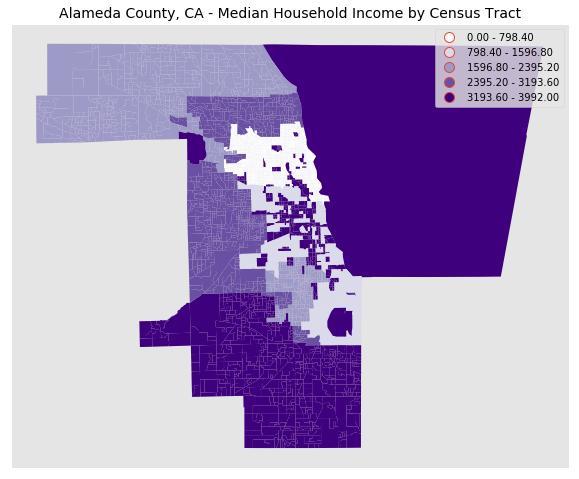

In [45]:
geodata_test = geodata[["geometry", "COUNTY", "GEO_ID"]].loc[geodata["COUNTY"] == "031"]
fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal', xticks=[], yticks=[])
geodata_test.plot(column= "GEO_ID", ax = ax, scheme='equal_interval', cmap='Purples', legend=True)
plt.title('Alameda County, CA - Median Household Income by Census Tract', size = 14)

In [38]:
geodata_test.head(100)

,geometry,COUNTY,GEO_ID
0,"POLYGON ((-9763920.5912 5169700.912799999, -97...",031,170318091003
1,POLYGON ((-9764807.139599999 5145329.259800002...,031,170312315004
2,POLYGON ((-9765878.144400001 5131687.360299997...,031,170315703002
3,"POLYGON ((-9766164.2355 5132229.018799998, -97...",031,170315703003
4,POLYGON ((-9765208.557700001 5132245.446699999...,031,170315704001
5,"POLYGON ((-9765338.5789 5131969.162199996, -97...",031,170315704002
6,POLYGON ((-9766682.316400001 5131040.904799998...,031,170315705001
9,POLYGON ((-9774273.415200001 5138591.732000001...,031,170318148005
10,"POLYGON ((-9772718.2819 5139448.085900001, -97...",031,170318149001
11,"POLYGON ((-9772712.048 5139150.071999997, -977...",031,170318149002
